# Séries Temporais e Forecast
## Atividade de desenvolvimento de análise de série temporal e forecast de uma base de dados de passageiros aéreos.
## Base de dados: https://www.kaggle.com/datasets/rakannimer/air-passengers

#### 1) Importação das bibliotecas necessárias



In [10]:
# --- pandas
import pandas as pd

# --- configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# --- sklearn e skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### 2) Carregamento e leitura da base de dados



In [11]:
url = 'https://raw.githubusercontent.com/drisabelles/aprendizagem-maquina/main/AirPassengers.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### 3) Tratamento dos dados

<Axes: xlabel='date'>

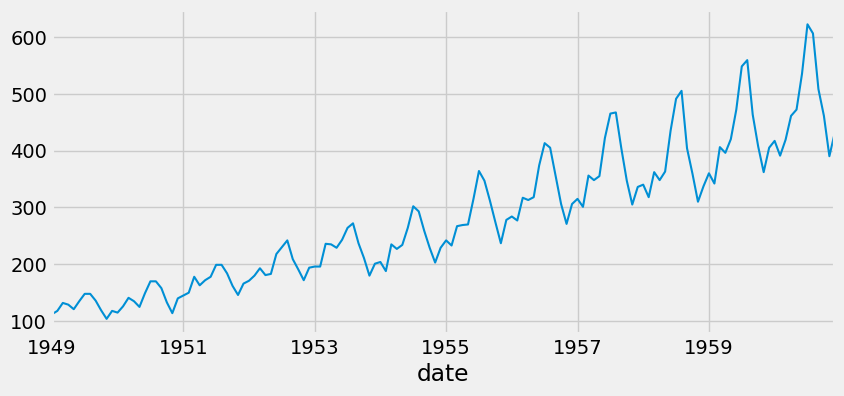

In [12]:
# --- renomeia a coluna de nomeada 'month' e a coluna nomeada '#Passengers'
data = data.rename(columns={'Month': 'date', '#Passengers': 'passengers'})

# --- converte data de string para datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# --- seta o índice
data = data.set_index('date')

# --- define a frequência (mensal). Caso falte registro, cria um novo e preenche as demais colunas com 0.0
data = data.asfreq('MS', fill_value=0.0)

# --- ordena pela data
data = data.sort_index()

# --- plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
data['passengers'].plot(ax=ax, label='passengers')

#### 4) Printa o número de linhas que tenham valores faltando

In [13]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


#### 5) Verifica se não existem "buracos" nos dados

In [14]:
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

#### 6) Dividindo os dados em treinamento e teste

Train dates : 1949-01-01 00:00:00 --- 1957-12-01 00:00:00  (n=108)
Test dates  : 1958-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=36)


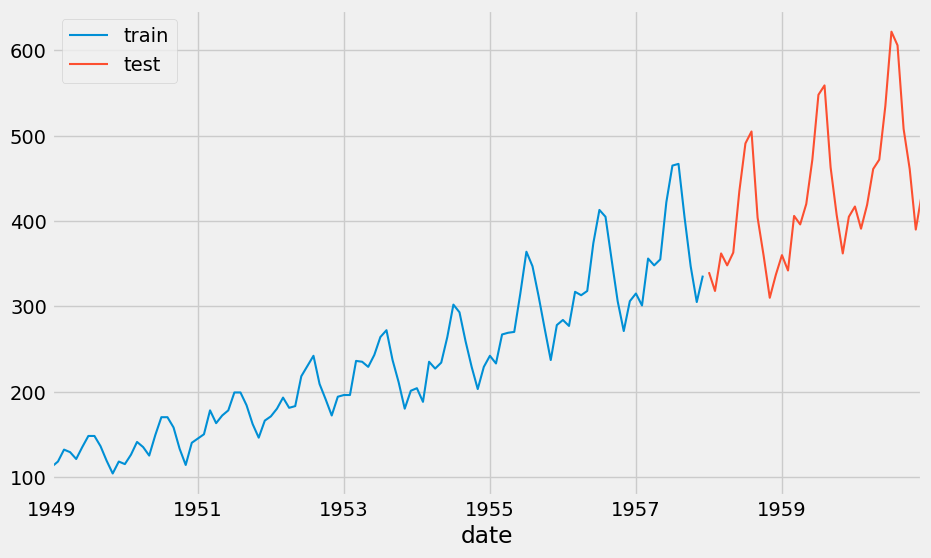

In [15]:
# --- para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# --- plotando os dados
fig, ax=plt.subplots(figsize=(10, 6))
data_train['passengers'].plot(ax=ax, label='train')
data_test['passengers'].plot(ax=ax, label='test')
ax.legend();

#### 7) Configura e treina um RandomForestRegressor para série temporal

In [16]:
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['passengers'], exog=data_train['passengers'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: passengers 
Training range: [Timestamp('1949-01-01 00:00:00'), Timestamp('1957-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-18 14:25:42 
Last fit date: 2023-04-18 14:25:42 
Skforecast version: 0.7.0

#### 8) Faz predição no conjunto de teste

In [17]:
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test['passengers'])
predictions.head(5)

1958-01-01    343.76
1958-02-01    317.46
1958-03-01    365.52
1958-04-01    351.08
1958-05-01    364.70
Freq: MS, Name: pred, dtype: float64

#### 9) Plota a predição, comparando com valores reais

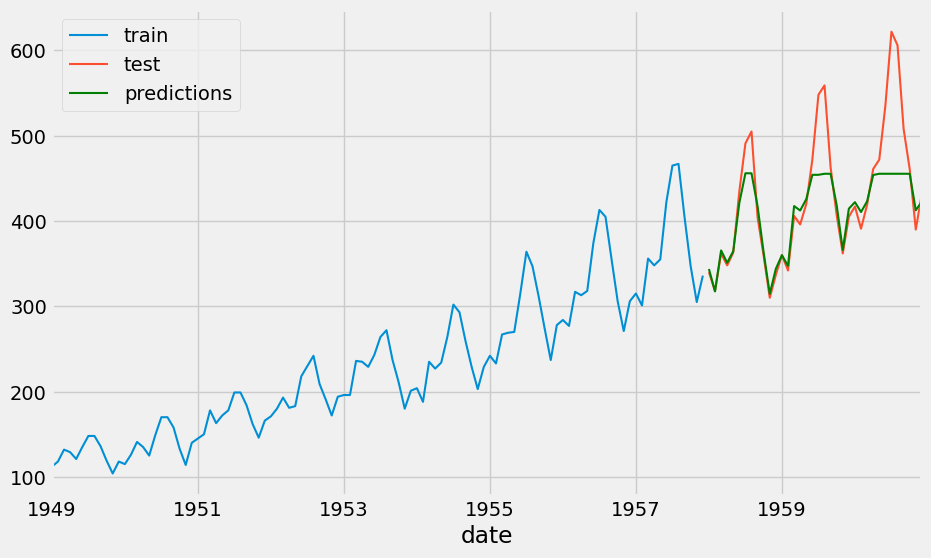

In [18]:
fig, ax=plt.subplots(figsize=(10, 6))
data_train['passengers'].plot(ax=ax, label='train')
data_test['passengers'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();